In [1]:
import requests
import csv
import pandas as pd
import datetime
import os, sys
import numpy as np
from time import sleep
import datetime
import zipfile
import gzip
from pathlib import Path
import xml.etree.ElementTree as XET
from tqdm import tqdm_notebook
%matplotlib inline
#載入plotly套件，版本須大於1.9.0
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# print(__version__)\n"
#載入cufflinks套件\n"
import cufflinks as cf
#連線用
init_notebook_mode(connected=True)

#離線用
cf.go_offline()

In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (2).csv
Saving train.csv to train (2).csv


In [3]:
file = list(uploaded.keys())
train = pd.read_csv( file[1], encoding = 'utf-8-sig')
test = pd.read_csv( file[0], encoding = 'utf-8-sig')

In [4]:
print(len(train))
print(len(test))

8100
900


In [5]:
trainID = train['ID'].unique()
testID = test['ID'].unique()


In [6]:
alldata = train
alldata = alldata.append(test)
alldata = alldata.reset_index(drop=True)
alldata

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,8773,0,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.4,2,3.0,11.0,3.0,7.0,2.0,0,0.0
1,6709,0,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,9,1.0,10.0,0.0,8.0,2.0,0,0.0
2,1463,9,301.000000,0,0.0,38,2621.621429,0.021212,0.044508,10.721172,0.0,8,1.0,10.0,0.0,14.0,2.0,0,0.0
3,4095,2,13.333333,0,0.0,105,2062.443592,0.012205,0.020276,0.000000,0.6,2,5.0,10.0,0.0,7.0,2.0,0,0.0
4,3346,0,0.000000,0,0.0,19,220.384849,0.010526,0.024642,0.000000,0.0,2,1.0,1.0,0.0,7.0,2.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,5887,2,738.000000,0,0.0,26,1840.666667,0.008000,0.042000,0.000000,0.0,2,1.0,10.0,3.0,14.0,2.0,0,NaN
8996,5273,0,0.000000,2,26.5,149,6001.171475,0.004000,0.022011,0.000000,0.0,8,1.0,10.0,0.0,4.0,2.0,0,NaN
8997,5833,0,0.000000,0,0.0,2,0.000000,0.200000,0.200000,0.000000,0.6,2,3.0,3.0,0.0,12.0,2.0,0,NaN
8998,2119,0,0.000000,0,0.0,15,263.250000,0.013333,0.040000,0.000000,0.0,8,3.0,3.0,6.0,5.0,2.0,1,NaN


In [7]:
# 檢查資料有無重複值
alldata[alldata.duplicated()]

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue


In [8]:
# one hot encoding處裡
TrafficType2 = pd.get_dummies(alldata.TrafficType, prefix='TrafficType')
Browser2 = pd.get_dummies(alldata.Browser, prefix='Browser')
OperatingSystems2 = pd.get_dummies(alldata.OperatingSystems, prefix='OperatingSystems')
VisitorType2 = pd.get_dummies(alldata.VisitorType, prefix='VisitorType')

one_hot_columns=pd.concat([TrafficType2, Browser2, OperatingSystems2, VisitorType2], axis=1)
one_hot_columns

,TrafficType_0.0,TrafficType_1.0,TrafficType_2.0,TrafficType_3.0,TrafficType_4.0,TrafficType_5.0,TrafficType_6.0,TrafficType_7.0,TrafficType_8.0,TrafficType_9.0,TrafficType_10.0,TrafficType_11.0,TrafficType_12.0,TrafficType_13.0,TrafficType_14.0,TrafficType_15.0,TrafficType_16.0,TrafficType_17.0,TrafficType_18.0,TrafficType_19.0,Browser_0.0,Browser_1.0,Browser_2.0,Browser_3.0,Browser_4.0,Browser_5.0,Browser_6.0,Browser_7.0,Browser_8.0,Browser_9.0,Browser_10.0,Browser_11.0,Browser_12.0,OperatingSystems_0.0,OperatingSystems_1.0,OperatingSystems_2.0,OperatingSystems_3.0,OperatingSystems_4.0,OperatingSystems_5.0,OperatingSystems_6.0,OperatingSystems_7.0,VisitorType_0.0,VisitorType_1.0,VisitorType_2.0
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
8996,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
8997,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
8998,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [9]:
alldata = alldata.drop(['TrafficType','Browser','OperatingSystems','VisitorType'],axis=1)
alldata = pd.concat([alldata, one_hot_columns], axis=1)
alldata

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,Region,Weekend,Revenue,TrafficType_0.0,TrafficType_1.0,TrafficType_2.0,TrafficType_3.0,TrafficType_4.0,TrafficType_5.0,TrafficType_6.0,TrafficType_7.0,TrafficType_8.0,TrafficType_9.0,TrafficType_10.0,TrafficType_11.0,TrafficType_12.0,TrafficType_13.0,TrafficType_14.0,TrafficType_15.0,TrafficType_16.0,TrafficType_17.0,TrafficType_18.0,TrafficType_19.0,Browser_0.0,Browser_1.0,Browser_2.0,Browser_3.0,Browser_4.0,Browser_5.0,Browser_6.0,Browser_7.0,Browser_8.0,Browser_9.0,Browser_10.0,Browser_11.0,Browser_12.0,OperatingSystems_0.0,OperatingSystems_1.0,OperatingSystems_2.0,OperatingSystems_3.0,OperatingSystems_4.0,OperatingSystems_5.0,OperatingSystems_6.0,OperatingSystems_7.0,VisitorType_0.0,VisitorType_1.0,VisitorType_2.0
0,8773,0,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.4,2,3.0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,6709,0,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,9,0.0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,1463,9,301.000000,0,0.0,38,2621.621429,0.021212,0.044508,10.721172,0.0,8,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,4095,2,13.333333,0,0.0,105,2062.443592,0.012205,0.020276,0.000000,0.6,2,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
4,3346,0,0.000000,0,0.0,19,220.384849,0.010526,0.024642,0.000000,0.0,2,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,5887,2,738.000000,0,0.0,26,1840.666667,0.008000,0.042000,0.000000,0.0,2,3.0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
8996,5273,0,0.000000,2,26.5,149,6001.171475,0.004000,0.022011,0.000000,0.0,8,0.0,0,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
8997,5833,0,0.000000,0,0.0,2,0.000000,0.200000,0.200000,0.000000,0.6,2,0.0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
8998,2119,0,0.000000,0,0.0,15,263.250000,0.013333,0.040000,0.000000,0.0,8,6.0,1,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [10]:
trainData = pd.DataFrame()
for tmp in range(len(trainID)):
  id = trainID[tmp]
  result = alldata[alldata['ID'] == id ]
  trainData = trainData.append(result)
  
testData = pd.DataFrame()
for tmp2 in range(len(testID)):
  id2 = testID[tmp2]
  result2 = alldata[alldata['ID'] == id2 ]
  testData = testData.append(result2)
testData

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,Region,Weekend,Revenue,TrafficType_0.0,TrafficType_1.0,TrafficType_2.0,TrafficType_3.0,TrafficType_4.0,TrafficType_5.0,TrafficType_6.0,TrafficType_7.0,TrafficType_8.0,TrafficType_9.0,TrafficType_10.0,TrafficType_11.0,TrafficType_12.0,TrafficType_13.0,TrafficType_14.0,TrafficType_15.0,TrafficType_16.0,TrafficType_17.0,TrafficType_18.0,TrafficType_19.0,Browser_0.0,Browser_1.0,Browser_2.0,Browser_3.0,Browser_4.0,Browser_5.0,Browser_6.0,Browser_7.0,Browser_8.0,Browser_9.0,Browser_10.0,Browser_11.0,Browser_12.0,OperatingSystems_0.0,OperatingSystems_1.0,OperatingSystems_2.0,OperatingSystems_3.0,OperatingSystems_4.0,OperatingSystems_5.0,OperatingSystems_6.0,OperatingSystems_7.0,VisitorType_0.0,VisitorType_1.0,VisitorType_2.0
8100,6162,0,0.0,0,0.0,12,482.500000,0.020000,0.040000,0.000000,0.0,8,0.0,0,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
8101,8143,3,33.0,0,0.0,17,386.416667,0.000000,0.010000,0.000000,0.0,9,0.0,0,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
8102,5571,0,0.0,0,0.0,9,154.800000,0.018182,0.030303,20.749351,0.0,8,2.0,0,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
8103,3933,5,79.0,1,12.0,54,1603.333333,0.005085,0.025424,0.000000,0.4,2,1.0,0,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
8104,934,2,17.0,1,105.0,9,148.250000,0.020000,0.022000,0.000000,0.0,1,0.0,0,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,5887,2,738.0,0,0.0,26,1840.666667,0.008000,0.042000,0.000000,0.0,2,3.0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
8996,5273,0,0.0,2,26.5,149,6001.171475,0.004000,0.022011,0.000000,0.0,8,0.0,0,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
8997,5833,0,0.0,0,0.0,2,0.000000,0.200000,0.200000,0.000000,0.6,2,0.0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
8998,2119,0,0.0,0,0.0,15,263.250000,0.013333,0.040000,0.000000,0.0,8,6.0,1,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [11]:
# 檢查資料有無nan值
trainData.isnull().values.any()
trainData = trainData.dropna()
trainData = trainData.reset_index(drop=True)


In [12]:
# Pearson相關係數，其中0表示它們之間沒有相關性。 接近-1或+1的相關性意味著極強的線性關係
train_corr = trainData.corr()
train_corr

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,Region,Weekend,Revenue,TrafficType_0.0,TrafficType_1.0,TrafficType_2.0,TrafficType_3.0,TrafficType_4.0,TrafficType_5.0,TrafficType_6.0,TrafficType_7.0,TrafficType_8.0,TrafficType_9.0,TrafficType_10.0,TrafficType_11.0,TrafficType_12.0,TrafficType_13.0,TrafficType_14.0,TrafficType_15.0,TrafficType_16.0,TrafficType_17.0,TrafficType_18.0,TrafficType_19.0,Browser_0.0,Browser_1.0,Browser_2.0,Browser_3.0,Browser_4.0,Browser_5.0,Browser_6.0,Browser_7.0,Browser_8.0,Browser_9.0,Browser_10.0,Browser_11.0,Browser_12.0,OperatingSystems_0.0,OperatingSystems_1.0,OperatingSystems_2.0,OperatingSystems_3.0,OperatingSystems_4.0,OperatingSystems_5.0,OperatingSystems_6.0,OperatingSystems_7.0,VisitorType_0.0,VisitorType_1.0,VisitorType_2.0
ID,1.000000,0.015988,0.017538,-0.000763,-0.002895,0.006942,-0.022253,0.015853,-0.001601,0.015532,-0.006628,-0.019989,-0.006686,-0.016310,-0.001527,-0.011421,-0.012724,-0.012845,-0.020390,-0.002104,0.012124,-0.007289,0.026497,-0.010500,-0.005011,-0.007477,0.008152,0.005385,-0.014318,-0.006716,-0.000797,-0.003318,-0.021795,0.007923,0.009884,-0.001827,0.001058,0.005226,0.001213,-0.009428,0.016216,0.018599,-0.003226,-0.009450,0.000637,0.000727,-0.012127,0.016153,-0.013431,-0.006407,0.016153,0.003383,0.016962,0.008348,-0.006628,-0.011466,0.012488,0.007394,-0.010130
Administrative,0.015988,1.000000,0.590089,0.385611,0.257866,0.437035,-0.007701,-0.072456,-0.314260,0.102046,-0.092223,0.089348,0.025785,0.005345,0.142824,-0.007751,0.026437,-0.009726,0.058020,0.107287,0.001296,-0.002939,0.002127,-0.061099,-0.007751,-0.009259,0.037448,-0.071318,0.008735,-0.031349,-0.033653,-0.006556,0.000904,-0.002359,-0.009897,-0.001039,-0.030527,-0.000565,-0.011223,-0.002502,-0.013497,0.001801,-0.002401,-0.012774,-0.028714,0.043524,-0.029067,-0.012832,-0.005019,0.012537,-0.012832,-0.007808,-0.019610,-0.000569,0.018695,-0.015234,-0.018654,0.033811,-0.028858
Administrative_Duration,0.017538,0.590089,1.000000,0.301112,0.249377,0.287215,-0.003434,-0.045534,-0.200476,0.075729,-0.071635,0.055235,0.017001,0.001531,0.095725,-0.004993,0.065184,-0.005721,0.014697,0.092616,-0.004231,-0.002126,-0.008825,-0.048733,-0.004993,-0.002185,0.028717,-0.061589,0.007797,-0.015752,-0.014599,-0.003663,-0.004226,0.009903,-0.008840,0.019073,-0.012501,0.005823,0.000584,0.006085,0.003904,-0.012931,-0.009813,0.001615,-0.011751,0.013111,-0.010045,-0.009718,-0.015740,-0.016652,-0.009718,0.010157,-0.002568,0.016464,0.016053,-0.003504,0.001620,0.031480,-0.031246
Informational,-0.000763,0.385611,0.301112,1.000000,0.603251,0.373987,-0.003440,-0.044842,-0.162045,0.043546,-0.046608,0.052779,-0.017627,0.009525,0.091260,-0.004400,0.078529,-0.007780,0.004538,0.108047,0.001353,0.003171,0.000633,-0.052353,-0.004400,-0.008591,0.006494,-0.060886,0.007619,-0.024166,-0.012879,-0.004966,-0.006223,-0.010396,-0.008948,-0.004400,-0.030450,-0.006202,-0.010254,-0.003661,-0.008884,-0.005140,-0.020746,-0.000259,-0.018681,0.045705,-0.029174,-0.005890,-0.016327,0.000997,-0.005890,-0.008202,-0.012661,0.017831,0.005963,-0.005046,-0.014351,-0.041077,0.043592
Informational_Duration,-0.002895,0.257866,0.249377,0.603251,1.000000,0.295300,-0.002303,-0.155886,-0.104246,0.033385,-0.021644,0.030823,-0.012590,0.002088,0.068637,-0.002703,0.061022,-0.003213,-0.012716,0.088434,-0.009852,0.054357,-0.006172,-0.041152,-0.002703,-0.011626,0.014404,-0.043918,-0.003485,-0.014984,-0.019485,-0.002804,-0.003823,-0.002550,-0.008962,-0.002703,-0.019101,-0.005309,-0.027762,0.005413,-0.013650,-0.004590,-0.022012,0.015923,-0.015918,0.048112,-0.024034,-0.005568,-0.013907,0.044764,-0.005568,-0.027619,-0.007328,-0.019070,-0.002491,0.002345,-0.008785,-0.038082,0.039372
ProductRelated,0.006942,0.437035,0.287215,0.373987,0.295300,1.000000,-0.006335,-0.069869,-0.288538,0.051554,-0.024643,0.153743,-0.023692,0.004348,0.149120,-0.007117,0.066489,-0.010829,-0.047597,

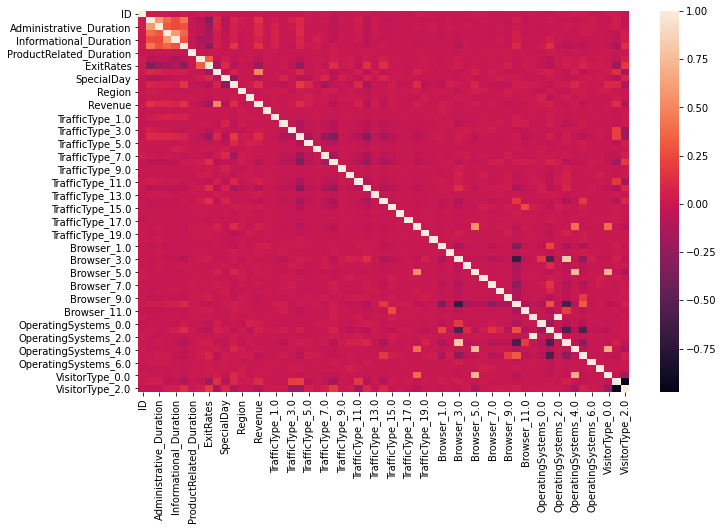

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(11,7))
sns.heatmap(train_corr)
plt.show()

In [14]:
# 取係數較接近1(前十)與-1(前十)的因子
print(train_corr['Revenue'].nlargest(11)) 

print(train_corr['Revenue'].nsmallest(10))


Revenue                    1.000000
PageValues                 0.499484
ProductRelated             0.149120
Administrative             0.142824
Month                      0.127911
TrafficType_4.0            0.118530
VisitorType_1.0            0.116568
Administrative_Duration    0.095725
Informational              0.091260
Informational_Duration     0.068637
TrafficType_11.0           0.057894
Name: Revenue, dtype: float64
ExitRates              -0.207749
VisitorType_2.0        -0.116702
TrafficType_12.0       -0.089638
SpecialDay             -0.076330
TrafficType_8.0        -0.067695
OperatingSystems_5.0   -0.063148
TrafficType_14.0       -0.062646
BounceRates            -0.050013
Browser_9.0            -0.026544
TrafficType_10.0       -0.024557
Name: Revenue, dtype: float64


In [15]:
X_train = trainData[['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'Region', 'Weekend', 'TrafficType_0.0', 'TrafficType_1.0',
       'TrafficType_2.0', 'TrafficType_3.0', 'TrafficType_4.0',
       'TrafficType_5.0', 'TrafficType_6.0', 'TrafficType_7.0',
       'TrafficType_8.0', 'TrafficType_9.0', 'TrafficType_10.0',
       'TrafficType_11.0', 'TrafficType_12.0', 'TrafficType_13.0',
       'TrafficType_14.0', 'TrafficType_15.0', 'TrafficType_16.0',
       'TrafficType_17.0', 'TrafficType_18.0', 'TrafficType_19.0',
       'Browser_0.0', 'Browser_1.0', 'Browser_2.0', 'Browser_3.0',
       'Browser_4.0', 'Browser_5.0', 'Browser_6.0', 'Browser_7.0',
       'Browser_8.0', 'Browser_9.0', 'Browser_10.0', 'Browser_11.0',
       'Browser_12.0', 'OperatingSystems_0.0', 'OperatingSystems_1.0',
       'OperatingSystems_2.0', 'OperatingSystems_3.0', 'OperatingSystems_4.0',
       'OperatingSystems_5.0', 'OperatingSystems_6.0', 'OperatingSystems_7.0',
       'VisitorType_0.0', 'VisitorType_1.0', 'VisitorType_2.0']]
y_train = trainData[['Revenue']]

In [16]:
# 計算有訂房筆數與沒訂房筆數
print('沒訂房:',len(trainData[trainData['Revenue']==0]))
print('有訂房:',len(trainData[trainData['Revenue']==1]))
#資料平衡
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42,kind='borderline-1')
X_res,y_res=sm.fit_resample(X_train,y_train)

print('Resample dataset shape %s' % Counter(y_res))

沒訂房: 6821
有訂房: 1277


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is depre

Resample dataset shape Counter({0.0: 6821, 1.0: 6821})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [17]:
from sklearn.model_selection import train_test_split
# 從訓練集資料裡面再分8:2訓練驗證資料
X_train2, X_val, y_train2, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
#正規化-------------------------------------------------------------

In [18]:

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_minmax_train = min_max_scaler.fit_transform(X_train2)
x_minmax_val = min_max_scaler.transform(X_val)



隨機森林挑特徵



In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from hyperopt import tpe

In [20]:
rf_model = RandomForestClassifier(n_estimators =1000, n_jobs = -1,random_state = 45,
                              max_features = 'auto')
rf_model.fit(X_train2,y_train2)
y_val_predicted = rf_model.predict(X_val)
accuracy = metrics.accuracy_score(y_val, y_val_predicted)
print(accuracy)
cm = confusion_matrix(y_val, y_val_predicted)
print(cm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=45, verbose=0,
                       warm_start=False)

In [21]:
feat_labels = X_train.columns
importances=rf_model.feature_importances_
indices=np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1,30,feat_labels[indices[f]],importances[indices[f]]))

 1) PageValues                     0.335857
 2) ProductRelated_Duration        0.065827
 3) ExitRates                      0.061437
 4) ProductRelated                 0.052461
 5) Administrative                 0.051041
 6) Month                          0.047437
 7) Administrative_Duration        0.044621
 8) TrafficType_4.0                0.039191
 9) BounceRates                    0.032865
10) OperatingSystems_1.0           0.025173
11) Region                         0.022011
12) Informational                  0.020519
13) TrafficType_8.0                0.017382
14) Informational_Duration         0.017117
15) OperatingSystems_5.0           0.016951
16) Browser_10.0                   0.016801
17) Weekend                        0.016031
18) TrafficType_12.0               0.015154
19) VisitorType_2.0                0.014842
20) OperatingSystems_3.0           0.014683
21) VisitorType_1.0                0.014565
22) Browser_3.0                    0.010108
23) TrafficType_7.0             

In [22]:
important_features = []
for f in range(20):
  important_features.append(feat_labels[indices[f]])

In [23]:
randforest_X_train = X_train[important_features]

In [24]:
# 計算有訂房筆數與沒訂房筆數
print('沒訂房:',len(trainData[trainData['Revenue']==0]))
print('有訂房:',len(trainData[trainData['Revenue']==1]))
#資料平衡
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42,kind='borderline-1')
X_res,y_res=sm.fit_resample(randforest_X_train,y_train)

print('Resample dataset shape %s' % Counter(y_res))

沒訂房: 6821
有訂房: 1277
Resample dataset shape Counter({0.0: 6821, 1.0: 6821})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [26]:
from sklearn.model_selection import train_test_split
# 從訓練集資料裡面再分8:2訓練驗證資料
X_train2, X_val, y_train2, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators =1000, n_jobs = -1,random_state = 45,
                              max_features = 'auto')
rf_model.fit(X_train2,y_train2)
y_val_predicted = rf_model.predict(X_val)
accuracy = metrics.accuracy_score(y_val, y_val_predicted)
print(accuracy)
cm = confusion_matrix(y_val, y_val_predicted)
print(cm)

0.9454012458776109
[[1281  102]
 [  47 1299]]


In [30]:

from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42,kind='borderline-1')
X_res,y_res=sm.fit_resample(X_train,y_train)
from sklearn.model_selection import train_test_split
# 從訓練集資料裡面再分8:2訓練驗證資料
X_train2, X_val, y_train2, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
#正規化-------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



xgboost特徵重要評分

In [32]:
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
clf = XGBClassifier(n_estimators=1000,learning_rate= 0.3,max_depth=6,subsample=1,gamma=0,reg_lambda=1)

# 模型 訓練
clf.fit(X_train2,y_train2,eval_metric='auc')

feat_labels = X_train.columns
importances=clf.feature_importances_
indices=np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1,30,feat_labels[indices[f]],importances[indices[f]]))
# # 預測值
# y_pred=clf.predict(X_val)
# # 真實值 賦值
# y_true= y_val

# # 計算精度
# print("Accuracy : %.4g" % metrics.accuracy_score(y_true, y_pred))


# cm = confusion_matrix(y_true, y_pred)
# cm

 1) PageValues                     0.160442
 2) TrafficType_11.0               0.069341
 3) VisitorType_2.0                0.068257
 4) VisitorType_1.0                0.060645
 5) TrafficType_14.0               0.058079
 6) TrafficType_4.0                0.054690
 7) TrafficType_2.0                0.052736
 8) TrafficType_3.0                0.038238
 9) TrafficType_7.0                0.037875
10) Month                          0.031646
11) OperatingSystems_3.0           0.028818
12) Browser_11.0                   0.027678
13) OperatingSystems_0.0           0.026538
14) TrafficType_12.0               0.026042
15) Browser_10.0                   0.023291
16) TrafficType_8.0                0.022490
17) Weekend                        0.018538
18) SpecialDay                     0.017177
19) TrafficType_15.0               0.015755
20) TrafficType_5.0                0.014240
21) Browser_8.0                    0.014132
22) Browser_1.0                    0.013524
23) OperatingSystems_1.0        

In [41]:
important_features = []
for f in range(41):
  important_features.append(feat_labels[indices[f]])

In [42]:
xg_X_train = X_train[important_features]

In [43]:
#資料平衡
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42,kind='borderline-1')
X_res,y_res=sm.fit_resample(xg_X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [44]:
from sklearn.model_selection import train_test_split
# 從訓練集資料裡面再分8:2訓練驗證資料
X_train2, X_val, y_train2, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
clf = XGBClassifier(n_estimators=1000,learning_rate= 0.3,max_depth=6,subsample=1,gamma=0,reg_lambda=1)

# 模型 訓練
clf.fit(X_train2,y_train2,eval_metric='auc')
y_val_predicted = clf.predict(X_val)
accuracy = metrics.accuracy_score(y_val, y_val_predicted)
print(accuracy)
cm = confusion_matrix(y_val, y_val_predicted)
print(cm)

0.9402711615976548
[[1294   89]
 [  74 1272]]


類神經

In [46]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [54]:
def build_model():
    model_input = layers.Input(shape = x_minmax_val.shape[-1])
    x = layers.Dense(32,activation='tanh')(model_input)
    x = layers.Dense(16,activation='tanh')(x)
    x = layers.Dense(4,activation='tanh')(x)
    model_output = layers.Dense(1,activation='sigmoid')(x)
    
    return Model(model_input ,model_output)

model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1856      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 2,457
Trainable params: 2,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam

optim = Adam()
model.compile(loss='binary_crossentropy',
              optimizer=optim,
              metrics=['acc'])

batch_size = 32
epochs = 1000

# 訓練模型
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/data_cosine2.h5', monitor='val_loss', save_best_only=True)
history = model.fit(x_minmax_train, y_train2,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_minmax_val, y_val),callbacks=[cp_callback])

from sklearn.metrics import mean_squared_error

model  = load_model('/data_cosine2.h5')
output = model.predict(x_minmax_val)

# mse = mean_squared_error(y_val, output)
# rmse = np.sqrt(mse)



In [59]:
new_output=[]
for b in range(len(output)):
  num = output[b]
  if num >0.5:
    num = 1
    new_output.append(num)

  else:
    num = 0
    new_output.append(num)
from sklearn.metrics import accuracy_score

print(accuracy_score(y_val, new_output))
NN_cm = confusion_matrix(y_val, new_output)
NN_cm

0.9278123854891902


array([[1268,  115],
       [  82, 1264]])

test輸入模型

In [60]:
testData = testData.drop(['Revenue'],axis=1)
# 檢查test資料有無nan值
testData = testData.dropna()
testData = testData.reset_index(drop=True)
# 檢查test資料有無重複值
testData[testData.duplicated()]
testData = testData.iloc[:,1:]
testData

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,Region,Weekend,TrafficType_0.0,TrafficType_1.0,TrafficType_2.0,TrafficType_3.0,TrafficType_4.0,TrafficType_5.0,TrafficType_6.0,TrafficType_7.0,TrafficType_8.0,TrafficType_9.0,TrafficType_10.0,TrafficType_11.0,TrafficType_12.0,TrafficType_13.0,TrafficType_14.0,TrafficType_15.0,TrafficType_16.0,TrafficType_17.0,TrafficType_18.0,TrafficType_19.0,Browser_0.0,Browser_1.0,Browser_2.0,Browser_3.0,Browser_4.0,Browser_5.0,Browser_6.0,Browser_7.0,Browser_8.0,Browser_9.0,Browser_10.0,Browser_11.0,Browser_12.0,OperatingSystems_0.0,OperatingSystems_1.0,OperatingSystems_2.0,OperatingSystems_3.0,OperatingSystems_4.0,OperatingSystems_5.0,OperatingSystems_6.0,OperatingSystems_7.0,VisitorType_0.0,VisitorType_1.0,VisitorType_2.0
0,0,0.0,0,0.0,12,482.500000,0.020000,0.040000,0.000000,0.0,8,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,3,33.0,0,0.0,17,386.416667,0.000000,0.010000,0.000000,0.0,9,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0.0,0,0.0,9,154.800000,0.018182,0.030303,20.749351,0.0,8,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,5,79.0,1,12.0,54,1603.333333,0.005085,0.025424,0.000000,0.4,2,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,2,17.0,1,105.0,9,148.250000,0.020000,0.022000,0.000000,0.0,1,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,2,738.0,0,0.0,26,1840.666667,0.008000,0.042000,0.000000,0.0,2,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
896,0,0.0,2,26.5,149,6001.171475,0.004000,0.022011,0.000000,0.0,8,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
897,0,0.0,0,0.0,2,0.000000,0.200000,0.200000,0.000000,0.6,2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
898,0,0.0,0,0.0,15,263.250000,0.013333,0.040000,0.000000,0.0,8,6.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [68]:
rand_X_test = testData[randforest_X_train.columns]
xg_X_test = testData[xg_X_train.columns].to_numpy()

In [63]:
# test 進隨機森林
predicted = rf_model.predict(rand_X_test)

predicted_randomforest = predicted.flatten()
predicted_randomforest

array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0.

In [69]:
#  test 進 XGBOOST
predicted_xg=clf.predict(xg_X_test)
predicted_xg

array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1.

In [71]:
x_minmax_test = min_max_scaler.transform(testData)
test_output = model.predict(x_minmax_test)
new_test_output=[]
for t in range(len(test_output)):
  num2 = output[t]
  if num2 >0.5:
    num2 = 1
    new_test_output.append(num2)

  else:
    num2 = 0
    new_test_output.append(num2)
new_test_output

[0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,


In [72]:
# 整理測試檔透過三種方法得出的預測結果
rf = pd.DataFrame(columns=['ID','HasRevenue_RandomForest','HasRevenue_xgboost','HasRevenue_nn'])
rf['HasRevenue_RandomForest'] = predicted_randomforest
rf['ID'] = testID
rf['HasRevenue_xgboost'] = predicted_xg
rf['HasRevenue_nn'] = new_test_output
rf = rf.astype(int)

In [77]:
# 利用投票方式選出最後的結果(若有兩個方法以上是判定該ID為"訂房"，則該ID則會標記為訂房的結果)
rf = rf.set_index('ID')
rf['PerStatus'] = 999
for i in range(len(rf)):
  count = 0
  #print(answer.iloc[0])
  for j in range(3):
      if rf.iloc[i,j] == 1:
          count = count +1
  if count > 1 :
      rf['PerStatus'].iloc[i] =1
  else:
      rf['PerStatus'].iloc[i] =0

In [93]:
from google.colab import drive
drive.mount('/content/drive')
# rf = rf.rename(columns={"PerStatus": "HasRevenue"})
rf[['HasRevenue']].to_csv('/content/drive/MyDrive/HasRevenue_test.csv') #輸出檔案

print('finish!')

Mounted at /content/drive
finish!


,HasRevenue_RandomForest,HasRevenue_xgboost,HasRevenue_nn,PerStatus
ID,,,,
8143,0,0,1,0
3933,0,0,1,0
1332,0,0,1,0
3600,1,1,1,1
3466,0,0,1,0
...,...,...,...,...
3297,1,1,1,1
4280,0,0,1,0
6106,0,0,1,0
